# Read and Extract ROI from LUNA16 dataset

Follows [this article](https://notebook.community/mas-dse-greina/neon/luna16/old_code/LUNA16_loader).

In [1]:
import numpy as np
import SimpleITK as sitk
import pandas as pd
import os
from os.path import join as path_join

import matplotlib.pyplot as plt
import ntpath
%matplotlib inline

In [2]:
LUNA_FOLDER = "../data/LUNA16"

# Images folder
LUNA_SEG_FOLDER = path_join(LUNA_FOLDER, "seg-lungs-LUNA16")
LUNA_SUBSET_0 = path_join(LUNA_FOLDER, "subset0")
LUNA_SUBSET_1 = path_join(LUNA_FOLDER, "subset1")

LUNA_CANDIDATES_CSV = path_join(LUNA_FOLDER, "candidates.csv")
LUNA_ANNOTATIONS_CSV = path_join(LUNA_FOLDER, "annotations.csv")

## Histogram of Nodules

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


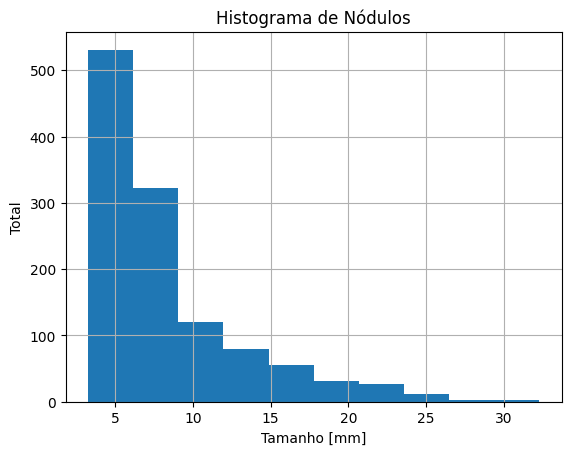

In [3]:
df_annotations = pd.read_csv(LUNA_ANNOTATIONS_CSV)
display(df_annotations.head())
df_annotations['diameter_mm'].hist();
plt.title('Histograma de Nódulos');
plt.xlabel('Tamanho [mm]');
plt.ylabel('Total');

In [4]:
df_candidates = pd.read_csv(LUNA_CANDIDATES_CSV)
df_candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0


In [5]:
# plot class bar chart

 

## Image Normalization

- Converting pixel value to Hounsfield Units (HU)

In [6]:
"""
Normalize pixel depth into Hounsfield units (HU)

This tries to get all pixels between -1000 and 400 HU.
All other HU will be masked.

"""
def normalizePlanes(npzarray):
     
    maxHU = 400.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

## Extract ROI Image Patches for Candidates

## Copied from LUNA16_loader

In [7]:
def extractCandidates(img_file, subset: str, window: int):
    # Get the name of the file
    subjectName = ntpath.splitext(ntpath.basename(img_file))[0]  # Strip off the .mhd extension
    
    # Read the list of candidate ROI
    dfCandidates = pd.read_csv(LUNA_CANDIDATES_CSV)
    dfAnnotations = pd.read_csv(LUNA_ANNOTATIONS_CSV)
    
    
    numCandidates = dfCandidates[dfCandidates['seriesuid']==subjectName].shape[0]
    print('There are {} candidate nodules in this file.'.format(numCandidates))
    
    numNonNodules = sum(dfCandidates[dfCandidates['seriesuid']==subjectName]['class'] == 0)
    numNodules = sum(dfCandidates[dfCandidates['seriesuid']==subjectName]['class'] == 1)
    print('{} are true nodules (class 1) and {} are non-nodules (class 0)'.format(numNodules, numNonNodules))
    
    # Read if the candidate ROI is a nodule (1) or non-nodule (0)
    candidateValues = dfCandidates[dfCandidates['seriesuid']==subjectName]['class'].values
    
    # Get the world coordinates (mm) of the candidate ROI center
    worldCoords = dfCandidates[dfCandidates['seriesuid']==subjectName][['coordX', 'coordY', 'coordZ']].values
    
    # Use SimpleITK to read the mhd image
    itkimage = sitk.ReadImage(path_join(subset,img_file))
    
    # Get the real world origin (mm) for this image
    originMatrix = np.tile(itkimage.GetOrigin(), (numCandidates,1))  # Real world origin for this image (0,0)
    
    # Subtract the real world origin and scale by the real world (mm per pixel)
    # This should give us the X,Y,Z coordinates for the candidates
    candidatesPixels = (np.round(np.absolute(worldCoords - originMatrix) / itkimage.GetSpacing())).astype(int)
    
    # Replace the missing diameters with the 50th percentile diameter 
    
    
    candidateDiameter = dfAnnotations['diameter_mm'].fillna(dfAnnotations['diameter_mm'].quantile(0.5)).values / itkimage.GetSpacing()[1]
     
    candidatePatches = []
    
    imgAll = sitk.GetArrayFromImage(itkimage) # Read the image volume
    
    for candNum in range(numCandidates):
        
        #print('Extracting candidate patch #{}'.format(candNum))
        candidateVoxel = candidatesPixels[candNum,:]
        xpos = int(candidateVoxel[0])
        ypos = int(candidateVoxel[1])
        zpos = int(candidateVoxel[2])
        
        # Need to handle the candidates where the window would extend beyond the image boundaries
        windowSize = window
        x_lower = np.max([0, xpos - windowSize])  # Return 0 if position off image
        x_upper = np.min([xpos + windowSize, itkimage.GetWidth()]) # Return  maxWidth if position off image
        
        y_lower = np.max([0, ypos - windowSize])  # Return 0 if position off image
        y_upper = np.min([ypos + windowSize, itkimage.GetHeight()]) # Return  maxHeight if position off image
        
        # crop the image for the double of candidate diameter
        
        # SimpleITK is x,y,z. Numpy is z, y, x.
        imgPatch = imgAll[zpos, y_lower:y_upper, x_lower:x_upper]
        
        # Normalize to the Hounsfield units
        # TODO: I don't think we should normalize into Housefield units
        imgPatchNorm = normalizePlanes(imgPatch)
         
        candidatePatches.append(imgPatchNorm)  # Append the candidate image patches to a python list

    return candidatePatches, candidateValues, candidateDiameter

In [8]:
IMAGES_FOLDER = LUNA_SUBSET_0 

In [9]:
# count mhd file in LUNA_SEG_FOLDER
import os
acc = 0
files = []
for f in os.listdir(IMAGES_FOLDER):
    if ".mhd" in f:
        acc += 1
        files.append(f)
        
#display(files)
print(f"There is {acc} CTs")

There is 89 CTs


In [10]:
patchesArray, valuesArray, noduleDiameter = extractCandidates(files[1], LUNA_SUBSET_0, 20)

There are 746 candidate nodules in this file.
1 are true nodules (class 1) and 745 are non-nodules (class 0)


In [11]:
EXTRACTED_PATCHES_DIR = "../data/extracted_patches"

In [12]:
import numpy as np
from scipy import ndimage

def resize(image, factor=2):
    # Assuming 'image' is your numpy array
    zoom_factor = factor  # 2 means doubling the size
    resized_image = ndimage.zoom(image, zoom_factor)
    return resized_image

    # Now 'resized_image' is the image with improved resolution

There are 1 positive candidates.


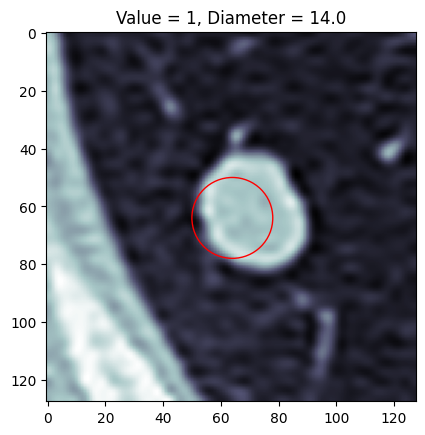

In [14]:
# Display the positive candidates (nodules)
import cv2
numPositives = np.where(valuesArray==1)[0]
print('There are {} positive candidates.'.format(len(numPositives)))

if (len(numPositives) > 1):
    plt.figure(figsize=(10,10))

for i, candidateNum in enumerate(numPositives):
    imgPatch = patchesArray[candidateNum]
    imgPatch = resize(imgPatch, factor=10)
    # resize image to 128x128
    imgPatch = cv2.resize(imgPatch, (128, 128))
    fig_name = path_join(EXTRACTED_PATCHES_DIR, f"all_lung_{i}.png")
    plt.imsave(fig_name, imgPatch)
    #cv2.imwrite(fig_name, imgPatch)
    plt.subplot(len(numPositives),1,i+1)
    plt.imshow(imgPatch, cmap='bone');
    plt.title('Value = {}, Diameter = {:.1f}'.format(valuesArray[candidateNum], noduleDiameter[candidateNum]));
    circle = plt.Circle((imgPatch.shape[0]/2, 
                         imgPatch.shape[1]/2), 
                        radius=noduleDiameter[candidateNum], fill=False, color='r')
    plt.gca().add_patch(circle)

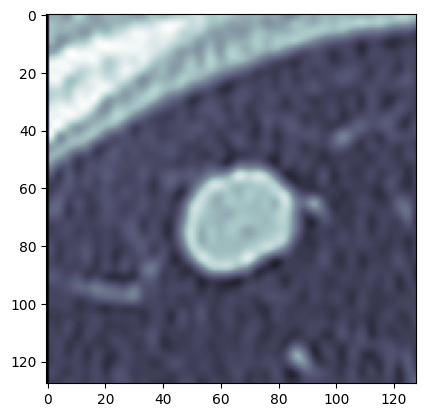

In [25]:
# rotate image
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread(path_join(EXTRACTED_PATCHES_DIR, "all_lung_0.png"),0)
rows,cols = img.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),270,1)
dst = cv2.warpAffine(img,M,(cols,rows))

plt.imshow(dst, cmap='bone')
plt.show()
